## **FACE MASK DETECTION:**

## Prepare the dataset

------

In [ ]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 12 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,257 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 6s (70.8 MB/s)
(Reading database ... 123069 files and directories currently installed.)
Removing libcudnn8-dev (8.9.0.131-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.9.0.131-1+cuda11.8 to 8.4.1.50-1+cuda11.6
(Reading database ... 123036 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1

In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from shutil import copyfile
import matplotlib.pyplot as plt

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7lQTJunJjBQHKweJnj4h")
project = rf.workspace("pyimagesearch").project("covid-19-pis")
dataset = project.version(2).download("folder")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=555a533d8cfda25eb1932b7c6e702bd44ef1b8efe7cbe687b5d094896a7eaa77
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Successfully uninstalled pyparsing-3.1.0
  Attempting uninstall: idna
    Found e

loading Roboflow workspace...
loading Roboflow project...

In [ ]:
source_path = '/content/Covid-19-PIS-2/train'

source_path_with_mask = os.path.join(source_path, 'with_mask')
source_path_without_mask = os.path.join(source_path, 'without_mask')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_with_mask))} images with mask.")
print(f"There are {len(os.listdir(source_path_without_mask))} images without mask.")

We need a directory for mask-v-no_mask, and subdirectories for training
and validation. These in turn will need subdirectories for 'mask' and 'no_mask'. To accomplish this, we define the function below

In [ ]:
# Define root directory

root_dir = '/tmp/mask-v-no_mask'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

#  create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
  source_dir = root_path
  os.makedirs(source_dir)

  training_dir = os.path.join(source_dir, 'training')
  os.makedirs(training_dir)
  training_mask_dir = os.path.join(training_dir, 'mask')
  os.makedirs(training_mask_dir)
  training_no_mask_dir = os.path.join(training_dir, 'no_mask')
  os.makedirs(training_no_mask_dir)

  validation_dir = os.path.join(source_dir, 'validation')
  os.makedirs(validation_dir)
  validation_mask_dir = os.path.join(validation_dir, 'mask')
  os.makedirs(validation_mask_dir)
  validation_mask_dir = os.path.join(validation_dir, 'no_mask')
  os.makedirs(validation_mask_dir)

  pass

  ### END CODE HERE

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

The `split_data` function which takes in the following arguments:
- SOURCE_DIR: directory containing the files

- TRAINING_DIR: directory that a portion of the files will be copied to (will be used for training)

- VALIDATION_DIR: directory that a portion of the files will be copied to (will be used for validation)

- SPLIT_SIZE: determines the portion of images used for training.

The files will be randomized, so that the training set is a random sample of the files, and the validation set is made up of the remaining files.

For example, if `SOURCE_DIR` is `PetImages/Cat`, and `SPLIT_SIZE` is .9 then 90% of the images in `PetImages/Cat` will be copied to the `TRAINING_DIR` directory
and 10% of the images will be copied to the `VALIDATION_DIR` directory.

All images should be checked before the copy, so if they have a zero file length, they will be omitted from the copying process. If this is the case then your function should print out a message such as `"filename is zero length, so ignoring."`. **You should perform this check before the split so that only non-zero images are considered when doing the actual split.**


Hints:

- `os.listdir(DIRECTORY)` returns a list with the contents of that directory.

- `os.path.getsize(PATH)` returns the size of the file

- `copyfile(source, destination)` copies a file from source to destination

- `random.sample(list, len(list))` shuffles a list

In [ ]:
# split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """
  ### START CODE HERE

  # To remove files with zero length/size
  source_dir_list = os.listdir(SOURCE_DIR)
  for fname in source_dir_list:
    filepath = os.path.join(SOURCE_DIR, fname)
    size = os.path.getsize(filepath)
    if size == 0:
      print(f'{f} is zero length, so ignoring.')
      os.remove(filepath)

  # generate the train size and list
  source_dir_list = os.listdir(SOURCE_DIR)
  train_size = int(len(source_dir_list) * SPLIT_SIZE)
  train_list = random.sample(source_dir_list, train_size)

  # Split
  for fname in source_dir_list:
    if fname in train_list:
      copyfile(os.path.join(SOURCE_DIR, fname), os.path.join(TRAINING_DIR, fname))
    else:
      copyfile(os.path.join(SOURCE_DIR, fname), os.path.join(VALIDATION_DIR, fname))
  pass

  ### END CODE HERE

In [ ]:
# Test your split_data function

# Define paths
MASK_SOURCE_DIR = "/content/Covid-19-PIS-2/train/with_mask"
NO_MASK_SOURCE_DIR = "/content/Covid-19-PIS-2/train/without_mask"

TRAINING_DIR = "/tmp/mask-v-no_mask/training"
VALIDATION_DIR = "/tmp/mask-v-no_mask/validation/"

MASK_TRAINING_DIR = os.path.join(TRAINING_DIR, "mask/")
MASK_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "mask/")

NO_MASK_TRAINING_DIR = os.path.join(TRAINING_DIR, "no_mask/")
NO_MASK_VALIDATION_DIR = os.path.join(VALIDATION_DIR, "no_mask/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(MASK_TRAINING_DIR)) > 0:
  for file in os.scandir(MASK_TRAINING_DIR):
    os.remove(file.path)
if len(os.listdir(MASK_VALIDATION_DIR)) > 0:
  for file in os.scandir(MASK_VALIDATION_DIR):
    os.remove(file.path)
if len(os.listdir(NO_MASK_TRAINING_DIR)) > 0:
  for file in os.scandir(NO_MASK_TRAINING_DIR):
    os.remove(file.path)
if len(os.listdir(NO_MASK_VALIDATION_DIR)) > 0:
  for file in os.scandir(NO_MASK_VALIDATION_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(MASK_SOURCE_DIR, MASK_TRAINING_DIR, MASK_VALIDATION_DIR, split_size)
split_data(NO_MASK_SOURCE_DIR, NO_MASK_TRAINING_DIR, NO_MASK_VALIDATION_DIR, split_size)


# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal mask's directory has {len(os.listdir(MASK_SOURCE_DIR))} images")
print(f"Original no_mask's directory has {len(os.listdir(NO_MASK_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(MASK_TRAINING_DIR))} images of mask for training")
print(f"There are {len(os.listdir(NO_MASK_TRAINING_DIR))} images of no_mask for training")
print(f"There are {len(os.listdir(MASK_VALIDATION_DIR))} images of mask for validation")
print(f"There are {len(os.listdir(NO_MASK_VALIDATION_DIR))} images of no_mask for validation")

Now that you have successfully organized the data in a way that can be easily fed to Keras' `ImageDataGenerator`, it is time for you to code the generators that will yield batches of images, both for training and validation. For this, complete the `train_val_generators` function below.

Something important to note is that the images in this dataset come in a variety of resolutions. Luckily, the `flow_from_directory` method allows you to standarize this by defining a tuple called `target_size` that will be used to convert each image to this target resolution. **For this exercise use a `target_size` of (150, 150)**.

In [ ]:
# train_val_generators

# construct the training image generator for data augmentation

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=25,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(225, 225))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255,
                                          rotation_range=25,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(225, 225))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

In [ ]:
#create_pre_trained_model
def create_pre_trained_model():
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  ### START CODE HERE
  pre_trained_model = MobileNetV2(input_shape=(225, 225, 3),
                                  include_top = False,
                                  weights = 'imagenet')

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model()

# Print the model summary
# pre_trained_model.summary()

To check that all the layers in the model were set to be non-trainable, you can also run the cell below:

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

## Creating callbacks for later

You have already worked with callbacks in the first course of this specialization so the callback to stop training once an accuracy of 99.9% is reached, is provided for you:

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
last_output = pre_trained_model.output
print(last_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [ ]:
# Get type of pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
# Create_final_model
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.AveragePooling2D(pool_size=(5, 5))(last_output)
  x = layers.Flatten(name="flatten")(x)
  x = layers.Dense(128, activation="relu")(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(2, activation="softmax")(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.inputs, outputs=x)

  # Compile the model
  print("[INFO] compiling model...")
  model.compile(optimizer = Adam(learning_rate=0.0001),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE

  return model


In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

[INFO] compiling model...
There are 2,422,210 total parameters in this model.
There are 164,226 trainable parameters in this model.


In [ ]:

# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 20,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/20
36/36 - 86s - loss: 0.6553 - accuracy: 0.6713 - val_loss: 0.3871 - val_accuracy: 0.9070 - 86s/epoch - 2s/step
Epoch 2/20
36/36 - 81s - loss: 0.3839 - accuracy: 0.8730 - val_loss: 0.2581 - val_accuracy: 0.9457 - 81s/epoch - 2s/step
Epoch 3/20
36/36 - 76s - loss: 0.3060 - accuracy: 0.8948 - val_loss: 0.2019 - val_accuracy: 0.9612 - 76s/epoch - 2s/step
Epoch 4/20
36/36 - 82s - loss: 0.2443 - accuracy: 0.9270 - val_loss: 0.1443 - val_accuracy: 0.9690 - 82s/epoch - 2s/step
Epoch 5/20
36/36 - 77s - loss: 0.2072 - accuracy: 0.9426 - val_loss: 0.1577 - val_accuracy: 0.9690 - 77s/epoch - 2s/step
Epoch 6/20
36/36 - 77s - loss: 0.1917 - accuracy: 0.9383 - val_loss: 0.1519 - val_accuracy: 0.9535 - 77s/epoch - 2s/step
Epoch 7/20
36/36 - 77s - loss: 0.1828 - accuracy: 0.9435 - val_loss: 0.1273 - val_accuracy: 0.9612 - 77s/epoch - 2s/step
Epoch 8/20
36/36 - 77s - loss: 0.1396 - accuracy: 0.9522 - val_loss: 0.1002 - val_accuracy: 0.9690 - 77s/epoch - 2s/step
Epoch 9/20
36/36 - 79s - loss: 0

In [ ]:
#Save Model
model.save("Face_Mask_Model.h5")

In [ ]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

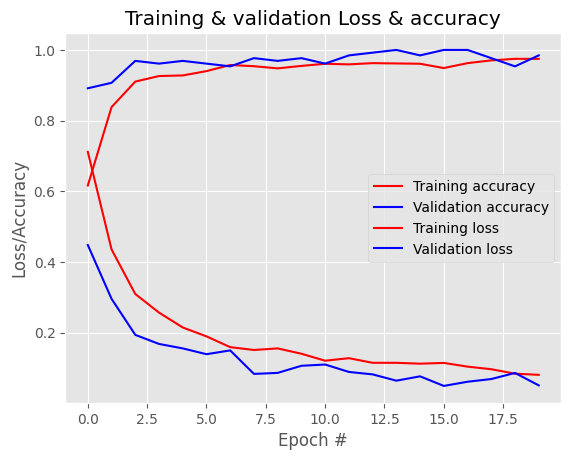

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use("ggplot")
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation Loss & accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc=0)
plt.figure()
plt.show()
plt.savefig("fig.png")


In [ ]:
# # make predictions on the testing set
# print("[INFO] evaluating network...")
# predIdxs = model.predict(testX, batch_size=BS)
# # for each image in the testing set we need to find the index of the
# # label with corresponding largest predicted probability
# predIdxs = np.argmax(predIdxs, axis=1)
# # show a nicely formatted classification report
# print(classification_report(testY.argmax(axis=1), predIdxs,
# 	target_names=lb.classes_))
# # serialize the model to disk
# print("[INFO] saving mask detector model...")
# model.save(args["model"], save_format="h5")

## Detect_image.py

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

In [ ]:
# construct the argument parser and parse the arguments


ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
	help="path to input image")
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())